# Garbage Classification using PyTorch

Garbage segregation involves separating wastes according to how it's handled or processed. It's important for recycling as some materials are recyclable and others are not.


![Garbage Bins](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwebstockreview.net%2Fimages%2Fgarbage-clipart-wastebin-16.png&f=1&nofb=1)


In this notebook we'll use PyTorch for classifying trash into various categories like metal, cardboard, etc.

Let us start by importing the libraries:

In [22]:
# import sys
# !{sys.executable} -m pip install -q kaggle
# !kaggle datasets download -d asdasdasasdas/garbage-classification -p ../data/raw/
# !unzip ../data/raw/garbage-classification.zip -d ../data/raw


In [23]:
import os
import random

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from codecarbon import EmissionsTracker
from torch.utils.data import Subset, random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid


Let us see the classes present in the dataset:

In [24]:
data_dir = "./data/raw/Garbage classification/Garbage classification/"

classes = os.listdir(data_dir)
print(classes)

['paper', 'metal', 'cardboard', 'trash', 'glass', 'plastic']


## Transformations:

Now, let's apply transformations to the dataset and import it for use.

In [25]:
transformations = transforms.Compose(
    [transforms.Resize((256, 256)), transforms.ToTensor()]
)

dataset = ImageFolder(data_dir, transform=transformations)

Let's create a helper function to see the image and its corresponding label:

In [26]:
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: cardboard (Class No: 0)


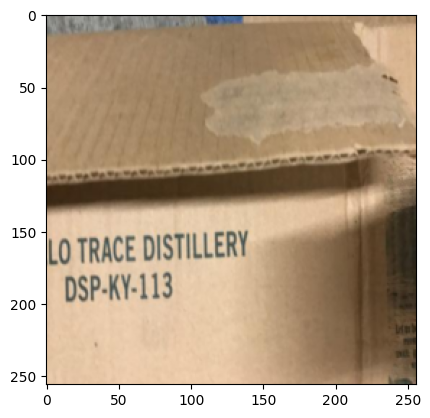

In [27]:
img, label = dataset[12]
show_sample(img, label)

# Loading and Splitting Data:

In [28]:
random_seed = 42
torch.manual_seed(random_seed)

We'll split the dataset into training, validation and test sets:

In [29]:
# train_ds, val_ds, test_ds = random_split(dataset, [1593, 176, 758])


indices = list(range(len(dataset)))
random_indices = random.sample(indices, 2527)

subset = Subset(dataset, random_indices)

train_ds, val_ds, test_ds = random_split(subset, [1593, 176, 758])
len(train_ds), len(val_ds), len(test_ds)

(1593, 176, 758)

In [30]:
batch_size = 32

Now, we'll create training and validation dataloaders using `DataLoader`.

In [31]:
train_dl = DataLoader(
    train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True
)
val_dl = DataLoader(val_ds, batch_size * 2, num_workers=4, pin_memory=True)

This is a helper function to visualize batches:

In [32]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [33]:
#show_batch(train_dl)

# Model Base:

Let's create the model base:

In [34]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)  # Calculate accuracy
        return {"val_loss": loss.detach(), "val_acc": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(
            "Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
                epoch + 1, result["train_loss"], result["val_loss"], result["val_acc"]
            )
        )

## Porting to GPU:

GPUs tend to perform faster calculations than CPU. Let's take this advantage and use GPU for computation:

In [35]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader:
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [36]:
device = get_default_device()
device

device(type='cpu')

# Training the Model:

This is the function for fitting the model.

In [37]:
@torch.no_grad()
def evaluate(model, val_loader, evaluation_name):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    results = model.validation_epoch_end(outputs)
    mlflow.log_metric(evaluation_name+"_val_loss",results["val_loss"])
    mlflow.log_metric(evaluation_name+"_val_acc",results["val_acc"])
    return results

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    mlflow.log_param("epochs",epochs)
    mlflow.log_param("lr",lr)
    mlflow.log_param("opt_func",(opt_func).__name__)
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader, "epoch_"+str(epoch))
        result["train_loss"] = torch.stack(train_losses).mean().item()
        mlflow.log_metric("epoch_"+str(epoch)+"_train_loss", result["train_loss"])
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Let's start training the model:

In [38]:
class CustomModel(ImageClassificationBase):
    def __init__(self, model_name):
        super().__init__()
        if model_name == "resnet18":
            self.network = models.resnet18(pretrained=True)
        elif model_name == "resnet34":
            self.network = models.resnet34(pretrained=True)
        elif model_name == "resnet50":
            self.network = models.resnet50(pretrained=True)
        elif model_name == "resnet101":
            self.network = models.resnet101(pretrained=True)
        elif model_name == "resnet152":
            self.network = models.resnet152(pretrained=True)
        elif model_name == "vgg11":
            self.network = models.vgg11(pretrained=True)
        elif model_name == "vgg13":
            self.network = models.vgg13(pretrained=True)
        elif model_name == "vgg16":
            self.network = models.vgg16(pretrained=True)
        elif model_name == "vgg19":
            self.network = models.vgg19(pretrained=True)
        elif model_name == "wide_resnet50_2":
            self.network = models.wide_resnet50_2(pretrained=True)
        elif model_name == "wide_resnet101_2":
            self.network = models.wide_resnet101_2(pretrained=True)

        # handle final layer replacement here based on dataset classes
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))

    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [39]:
def train(model):
    num_epochs = 1
    mlflow.log_param("num_epochs", num_epochs)
    opt_func = torch.optim.Adam
    lr = 5.5e-5
    history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)
    return history


def tracksense(model):
    tracker = EmissionsTracker()
    tracker.start()
    train(model)
    tracker.stop()
    return tracker

In [40]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [41]:
test_data = []
for image, label in test_ds:
    test_data.append((image, dataset.classes[label]))


In [42]:
# mmodels_to_train = [
#    "resnet18", "resnet34", "resnet50", "resnet101", "resnet152",
#   "vgg11", "vgg13", "vgg16", "vgg19",
#   "wide_resnet50_2", "wide_resnet101_2"
# ]
import sys
import os

parent_dir = os.path.dirname('../')
sys.path.append(parent_dir)
from mlflow_emissions_sdk.experiment_tracking_training import EmissionsTrackerMlflow
models_to_train = ["resnet18", "resnet34"]
# Move dataloaders to device
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_ds, device)

for model_name in models_to_train:
    #mlflow.set_experiment("Carbon_Emissions_Experiment")
    #mlflow.run
    tracker_info = {
        "tracking_uri" : "http://127.0.0.1:5000",
        "experiment_name": "sdk_test_3",
        "run_name": f"{model_name}",
        "flavor": "pytorch"       #['pytorch', 'keras', 'scikit']
    }
    #with mlflow.start_run(run_name=model_name):
    print(f"Training {model_name}")

        # Initialize the model and move to device
    model = CustomModel(model_name)
    model = to_device(model, device)
    runner = EmissionsTrackerMlflow()
        # Evaluate the untrained model
    runner.read_params(tracker_info)
    #print(f"Evaluating untrained {model_name}")
    runner.start_training_job()
    #evaluate(model, val_dl, "untrained")
    #tracker = start_training_job()
    train(model)
    runner.end_training_job(model)
    runner.accuracy_per_emission(model, test_ds)
    runner.emission_per_10_inferences(model, test_ds)
        #tracker  = tracksense(model)


        # Output the emissions
        #emissions: float = tracker.stop()
        #mlflow.log_metric("emissions",emissions)
        #print(f"Emissions: {emissions} kg")

        # Evaluate the trained model
        #print(f"Evaluating trained {model_name}")
        #r = 0
        #for image, label in test_ds:
        #    result = predict_image(image,model)
        #    if result == dataset.classes[label]:
        #        r += 1
        #acc = r/len(test_ds)
        #mlflow.log_metric("test_acc",acc)
        #mlflow.log_metric("acc_per_emmisions",acc/(emissions*1000))


/Users/alial-gburi/rootsacademy/acad-proj/datar-mlflow-emissions/mlflow-emissions-sdk/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/alial-gburi/rootsacademy/acad-proj/datar-mlflow-emissions/mlflow-emissions-sdk/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
[codecarbon INFO @ 15:12:21] [setup] RAM Tracking...
[codecarbon INFO @ 15:12:21] [setup] GPU Tracking...
[codecarbon INFO @ 15:12:21] No GPU found.
[codecarbon INFO @ 15:12:21] [setup] CPU Tracking...
[codecarbon WAR

Training resnet18


[codecarbon WARNING @ 15:12:21] We saw that you have a Apple M2 Pro but we don't know it. Please contact us.
[codecarbon INFO @ 15:12:21] CPU Model on constant consumption mode: Apple M2 Pro
[codecarbon INFO @ 15:12:21] >>> Tracker's metadata:
[codecarbon INFO @ 15:12:21]   Platform system: macOS-14.0-arm64-arm-64bit
[codecarbon INFO @ 15:12:21]   Python version: 3.11.6
[codecarbon INFO @ 15:12:21]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 15:12:21]   Available RAM : 16.000 GB
[codecarbon INFO @ 15:12:21]   CPU count: 10
[codecarbon INFO @ 15:12:21]   CPU model: Apple M2 Pro
[codecarbon INFO @ 15:12:21]   GPU count: None
[codecarbon INFO @ 15:12:21]   GPU model: None
2023/10/23 15:12:24 INFO mlflow.tracking.fluent: Experiment with name 'sdk_test_3' does not exist. Creating a new experiment.
[codecarbon INFO @ 15:12:39] Energy consumed for RAM : 0.000025 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 15:12:39] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codeca

Epoch 1: train_loss: 1.5076, val_loss: 1.3321, val_acc: 0.8351


[codecarbon WARNING @ 15:15:41] Already started tracking
[codecarbon WARNING @ 15:15:41] Tracker already stopped !
[codecarbon INFO @ 15:15:41] Energy consumed for RAM : 0.000327 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 15:15:41] Energy consumed for all CPUs : 0.002319 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:15:41] 0.002646 kWh of electricity used since the beginning.
/Users/alial-gburi/rootsacademy/acad-proj/datar-mlflow-emissions/mlflow-emissions-sdk/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/alial-gburi/rootsacademy/acad-proj/datar-mlflow-emissions/mlflow-emissions-sdk/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equiva

Training resnet34


[codecarbon INFO @ 15:15:41] [setup] RAM Tracking...
[codecarbon INFO @ 15:15:41] [setup] GPU Tracking...
[codecarbon INFO @ 15:15:41] No GPU found.
[codecarbon INFO @ 15:15:41] [setup] CPU Tracking...
[codecarbon WARNING @ 15:15:41] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 15:15:41] We saw that you have a Apple M2 Pro but we don't know it. Please contact us.
[codecarbon INFO @ 15:15:41] CPU Model on constant consumption mode: Apple M2 Pro
[codecarbon INFO @ 15:15:41] >>> Tracker's metadata:
[codecarbon INFO @ 15:15:41]   Platform system: macOS-14.0-arm64-arm-64bit
[codecarbon INFO @ 15:15:41]   Python version: 3.11.6
[codecarbon INFO @ 15:15:41]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 15:15:41]   Available RAM : 16.000 GB
[codecarbon INFO @ 15:15:41]   CPU count: 10
[codecarbon INFO @ 15:15:41]   CPU model: Apple M2 Pro
[codecarbon INFO @ 15:15:41]   GPU count: None
[codecarbon INFO @ 15:15:41]   GPU model: None
[codecarbon INFO @ 15:

Epoch 1: train_loss: 1.4545, val_loss: 1.2644, val_acc: 0.8420


[codecarbon WARNING @ 15:20:32] Already started tracking
[codecarbon WARNING @ 15:20:32] Tracker already stopped !
[codecarbon INFO @ 15:20:32] Energy consumed for RAM : 0.000483 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 15:20:32] Energy consumed for all CPUs : 0.003424 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:20:32] 0.003907 kWh of electricity used since the beginning.


In [35]:
print(predict_image(test_data[3][0], model))
print(predict_image(test_data[3][0], model) == test_data[3][1])

paper
True


In [ ]:
print(model.get_parameter(''))

In [ ]:
r = 0
for image, label in test_ds:
    result = predict_image(image,model)
    if result == dataset.classes[label]:
        r += 1
acc = r/len(test_ds)

In [ ]:
df=mlflow.search_runs(experiment_names=["Carbon_Emissions_Experiment"])

df["metrics.emissions"].sum()
emissions/acc*1000


In [ ]:
def plot_accuracies(history):
    accuracies = [x["val_acc"] for x in history]
    plt.plot(accuracies, "-x")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Accuracy vs. No. of epochs")

tracker.flush()

In [ ]:
def plot_losses(history):
    train_losses = [x.get("train_loss") for x in history]
    val_losses = [x["val_loss"] for x in history]
    plt.plot(train_losses, "-bx")
    plt.plot(val_losses, "-rx")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of epochs")


plot_losses(history)

# Visualizing Predictions:

Let us see the model's predictions on the test dataset:

In [ ]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print("Label:", dataset.classes[label], ", Predicted:", predict_image(img, model))

In [ ]:
img, label = test_ds[0]
plt.imshow(img.permute(1, 2, 0))
print("Label:", dataset.classes[label], ", Predicted:", predict_image(img, model))

In [ ]:
img, label = test_ds[18]
plt.imshow(img.permute(1, 2, 0))
print("Label:", dataset.classes[label], ", Predicted:", predict_image(img, model))

# Conclusion:

Our model is able to classify garbage with **95% accuracy**!

It's great to see the model's predictions on the test set. It works pretty good on external images too!

You can try experimenting with more images and see the results!

### If you liked the kernel, don't forget to show some appreciation :)